In [61]:
pip install pydicom

In [62]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import joblib
import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint

In [63]:
# Load and preprocess training and testing data
train_data = pd.read_csv('/content/train[1].csv')
test_data = pd.read_csv('/content/test[1].csv')

In [64]:
# Check missing values
missing_values = train_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64


In [65]:
# Encode categorical and scale features
train_data['Sex'] = train_data['Sex'].map({'Male': 1, 'Female': 0})
data = pd.get_dummies(train_data, columns=['SmokingStatus'])
data['Abs_Weeks'] = data['Weeks'].abs()
scaler = MinMaxScaler()
data[['Age', 'FVC', 'Percent', 'Abs_Weeks']] = scaler.fit_transform(data[['Age', 'FVC', 'Percent', 'Abs_Weeks']])
print(data.head())

                     Patient  Weeks       FVC   Percent       Age  Sex  \
0  ID00007637202177411956430     -4  0.267050  0.236393  0.769231    1   
1  ID00007637202177411956430      5  0.248923  0.215941  0.769231    1   
2  ID00007637202177411956430      7  0.221464  0.184960  0.769231    1   
3  ID00007637202177411956430      9  0.236360  0.201767  0.769231    1   
4  ID00007637202177411956430     11  0.222900  0.186580  0.769231    1   

   SmokingStatus_Currently smokes  SmokingStatus_Ex-smoker  \
0                           False                     True   
1                           False                     True   
2                           False                     True   
3                           False                     True   
4                           False                     True   

   SmokingStatus_Never smoked  Abs_Weeks  
0                       False   0.030075  
1                       False   0.037594  
2                       False   0.052632  
3         

In [66]:
# Function to load and preprocess DICOM images
def load_dicom_image(filepath):
    dicom = pydicom.dcmread(filepath)
    image = dicom.pixel_array
    return image
# Path to DICOM folder for example CT scan images
dicom_folder_path = '/content/drive/MyDrive/test/ID00419637202311204720264'

In [67]:
# Load DICOM images from folder
def load_dicom_images(folder_path):
    image_slices = []
    for file_name in sorted(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, file_name)
        dicom = pydicom.dcmread(file_path)
        image = dicom.pixel_array
        image_slices.append(image)
    return image_slices

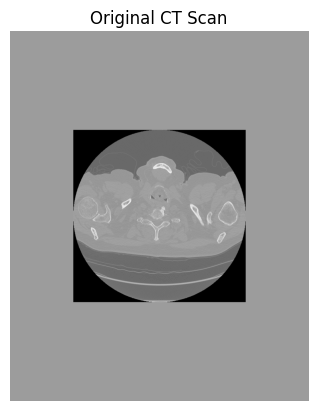

In [68]:
# Display CT scan slice, histogram, and segmented lungs
dicom_file = pydicom.dcmread('/content/drive/MyDrive/test/ID00419637202311204720264/1.dcm')
image = dicom_file.pixel_array
plt.imshow(image, cmap='gray')
plt.title('Original CT Scan')
plt.axis('off')
plt.show()

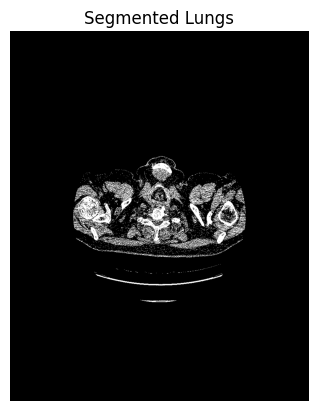

In [69]:
# Segment the lungs in the CT scan
lower_threshold = 50
upper_threshold = 255
_, segmented_lungs = cv2.threshold(image, lower_threshold, upper_threshold, cv2.THRESH_BINARY)
plt.imshow(segmented_lungs, cmap='gray')
plt.title('Segmented Lungs')
plt.axis('off')
plt.show()

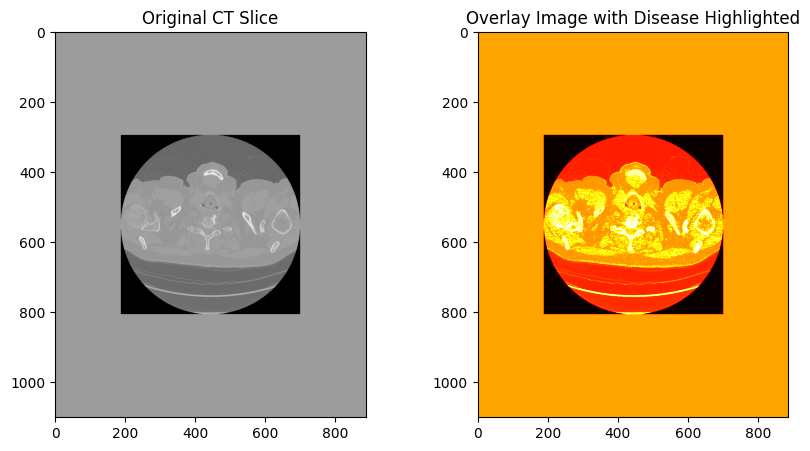

In [70]:
# Highlight disease areas in the CT scan image
disease_lower_bound = 100
disease_upper_bound = 1000
disease_mask = np.logical_and(image > disease_lower_bound, image < disease_upper_bound)
overlay_image = np.copy(image)
overlay_image[disease_mask] = np.max(image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original CT Slice')

plt.subplot(1, 2, 2)
plt.imshow(overlay_image, cmap='hot')
plt.title('Overlay Image with Disease Highlighted')
plt.show()

Disease Spread Score: 25754.14285714286
Disease Severity Level: High


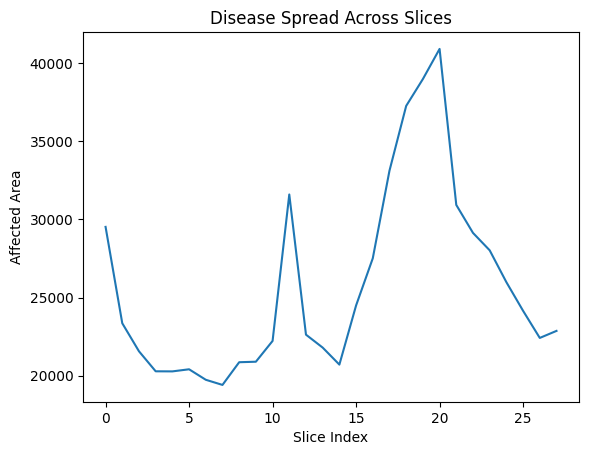

In [71]:
# Segment images and calculate affected area for disease spread prediction
def calculate_disease_spread(image_slices, lower_threshold=50, upper_threshold=200):
    affected_areas = []
    for slice in image_slices:
        # Segment areas within the intensity range of interest
        segmented_slice = cv2.inRange(slice, lower_threshold, upper_threshold)
        affected_area = np.sum(segmented_slice > 0)  # Count affected pixels
        affected_areas.append(affected_area)

    total_affected_area = sum(affected_areas)
    disease_spread_score = total_affected_area / len(image_slices)  # Average affected area per slice

    # Categorize spread score
    if disease_spread_score < 5000:
        spread_category = 'Low'
    elif disease_spread_score < 15000:
        spread_category = 'Medium'
    elif disease_spread_score < 30000:
        spread_category = 'High'
    else:
        spread_category = 'Severe'

    return disease_spread_score, spread_category, affected_areas
# Example folder path for DICOM files
dicom_folder_path = '/content/drive/MyDrive/test/ID00419637202311204720264'  # Replace with actual path
image_slices = load_dicom_images(dicom_folder_path)

# Calculate disease spread score and category
disease_spread_score, spread_category, affected_areas = calculate_disease_spread(image_slices)

# Display the results
print(f"Disease Spread Score: {disease_spread_score}")
print(f"Disease Severity Level: {spread_category}")

# Plot the affected area across slices for visual reference
plt.plot(affected_areas)
plt.title('Disease Spread Across Slices')
plt.xlabel('Slice Index')
plt.ylabel('Affected Area')
plt.show()

In [75]:
import plotly.graph_objects as go
import pandas as pd

# Convert affected areas into a DataFrame for easy plotting
slices_df = pd.DataFrame({'Slice': range(len(affected_areas)), 'Affected Area': affected_areas})

# Create a line plot with Plotly
fig = go.Figure()

# Add the line for affected area per slice
fig.add_trace(go.Scatter(
    x=slices_df['Slice'],
    y=slices_df['Affected Area'],
    mode='lines+markers',
    line=dict(color='firebrick'),
    name='Affected Area'
))

# Set up layout properties
fig.update_layout(
    title="Disease Spread Across CT Slices",
    xaxis_title="Slice Index",
    yaxis_title="Affected Area (pixels)",
    template="plotly_white",
    annotations=[
        dict(
            xref="paper", yref="paper", x=0.95, y=0.95, showarrow=False,
            text=f"Overall Spread Category: {spread_category}", font=dict(size=12)
        )
    ]
)

# Show the Plotly graph
fig.show()


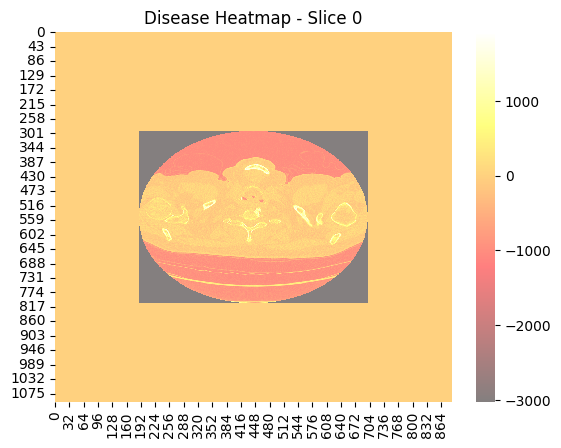

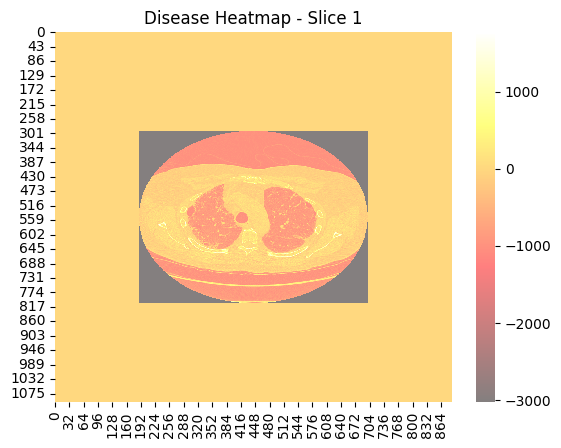

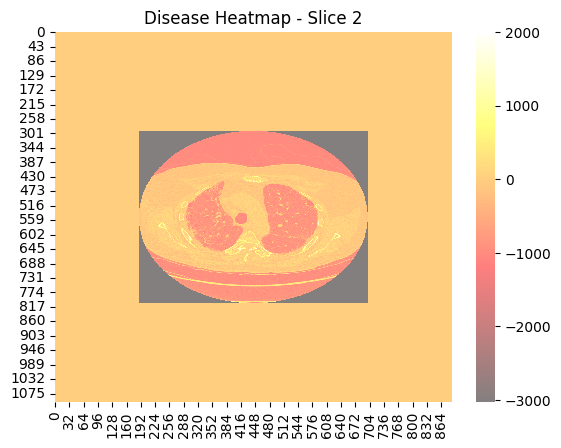

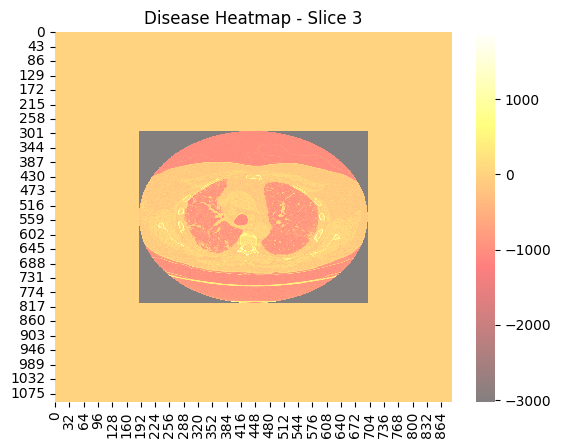

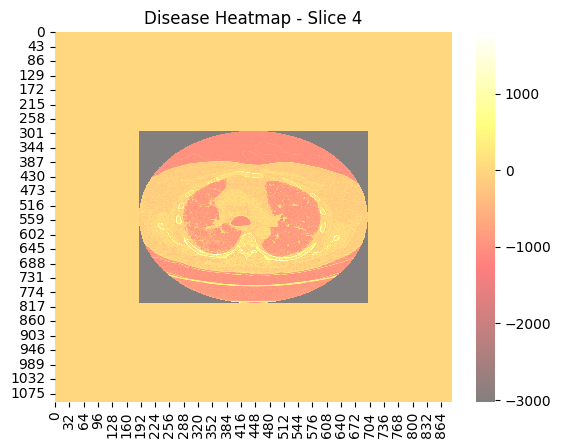

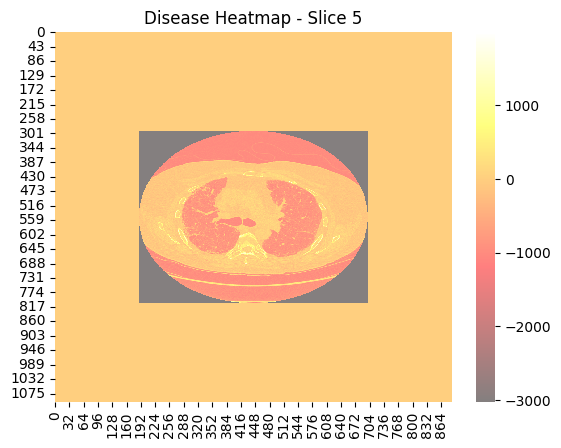

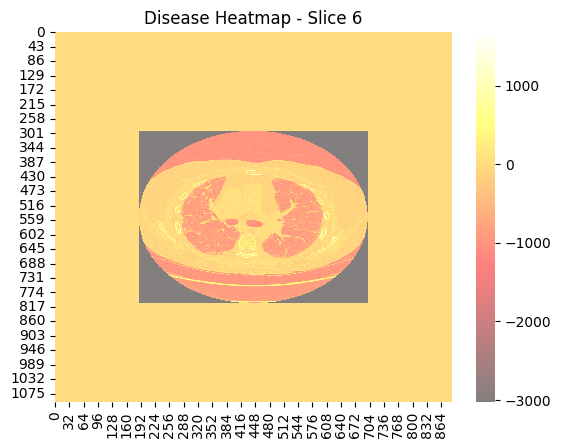

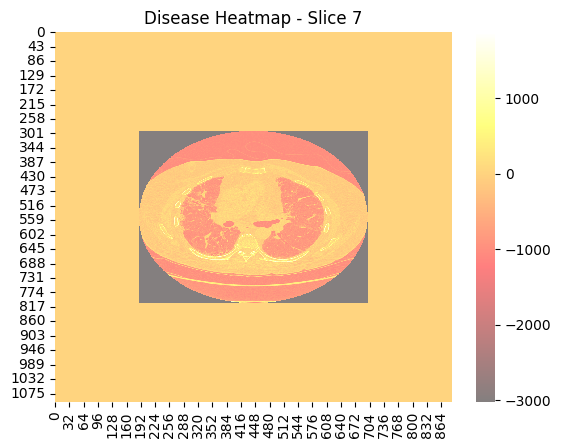

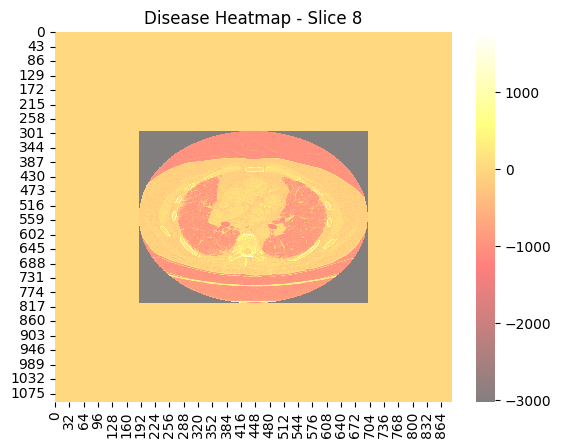

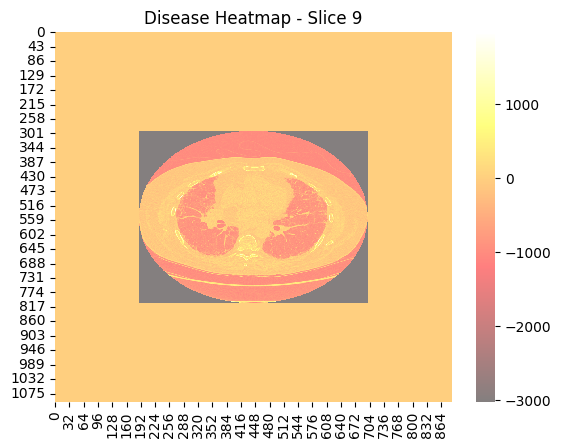

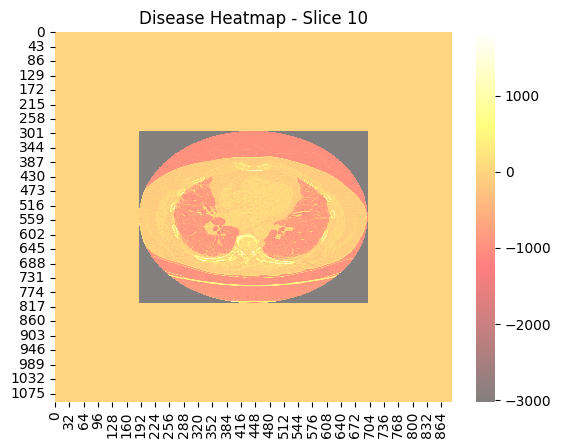

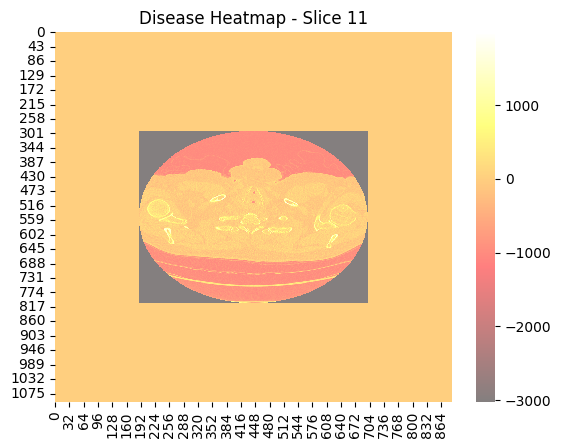

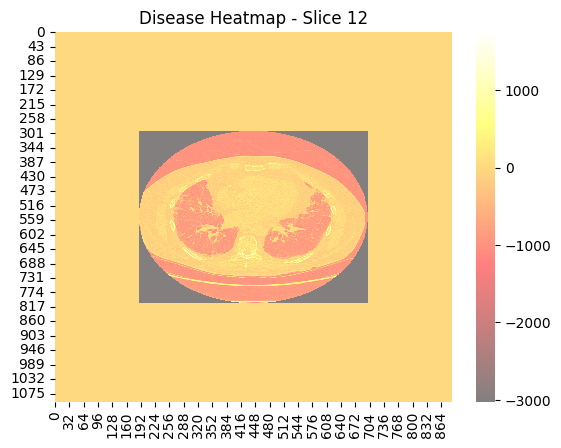

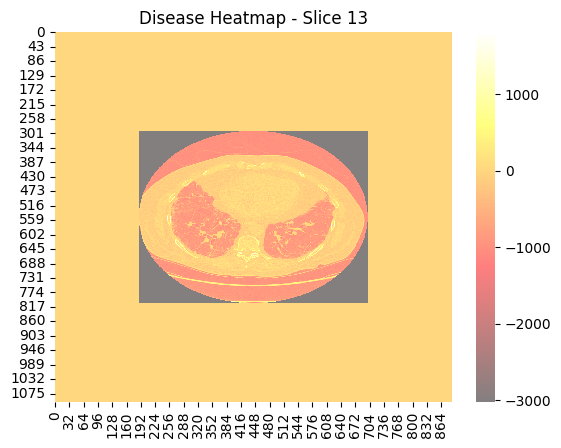

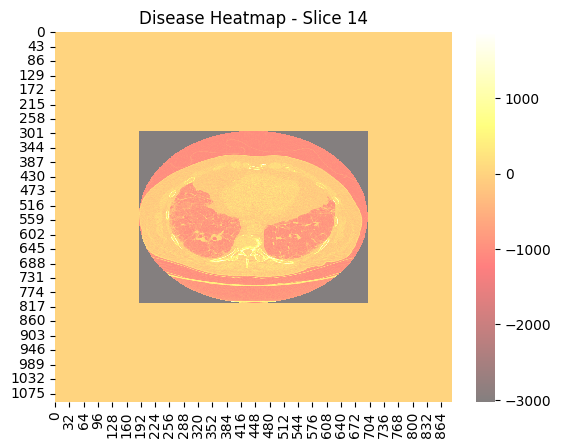

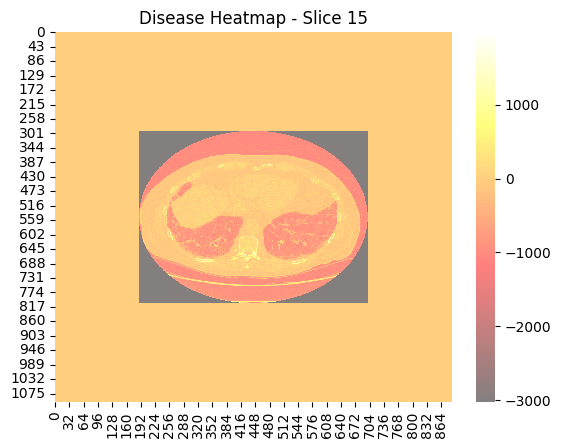

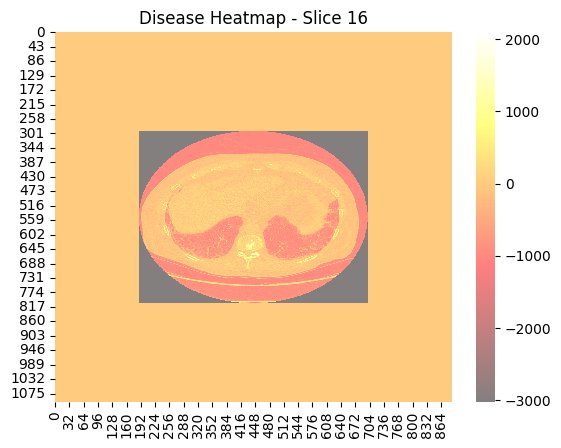

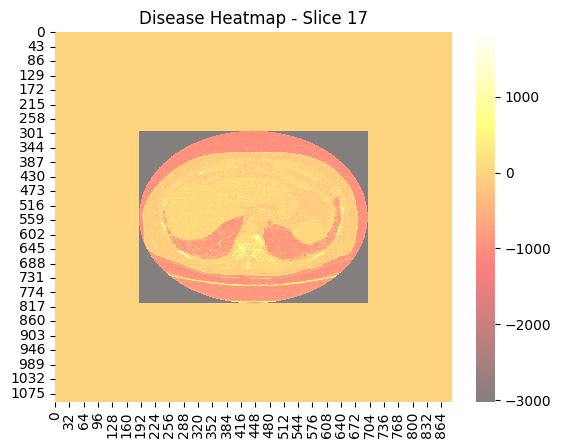

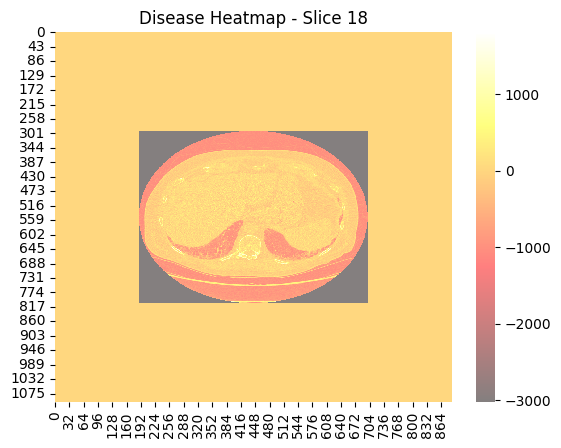

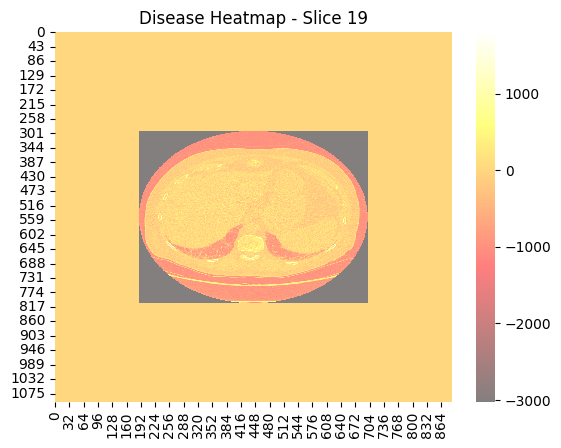

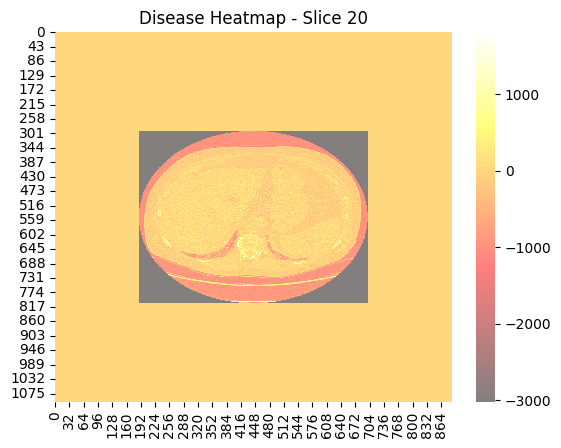

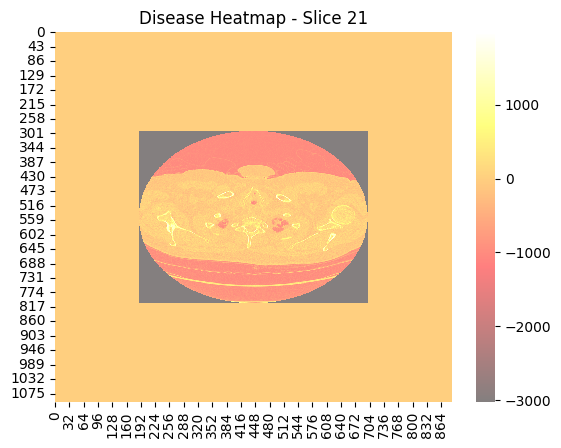

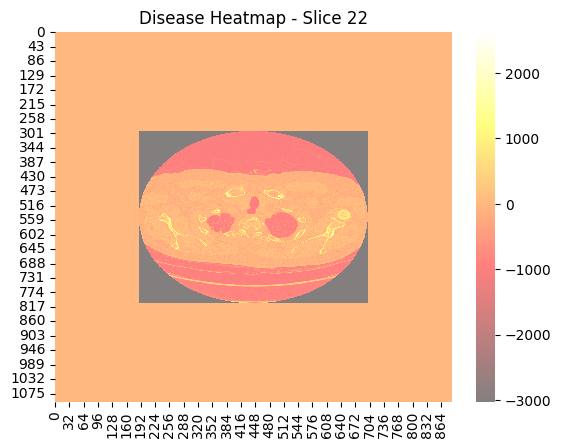

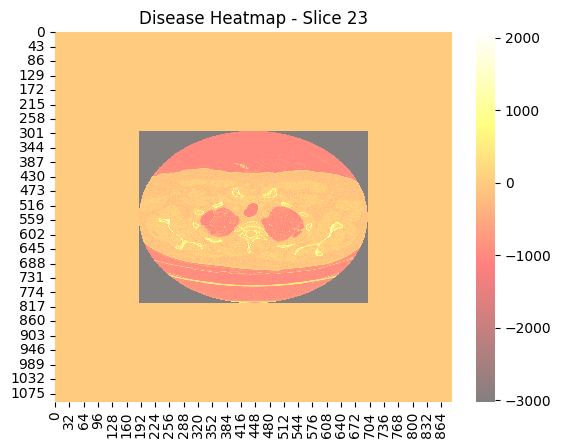

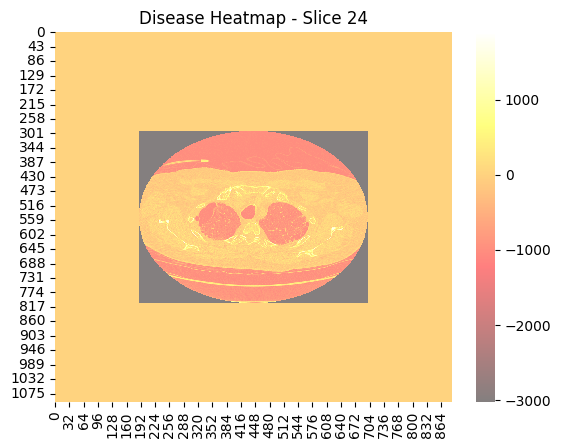

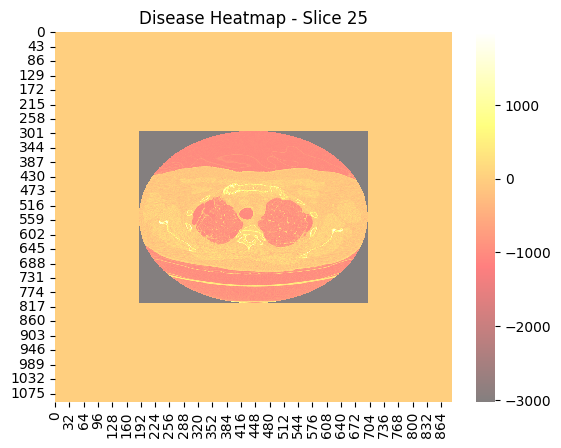

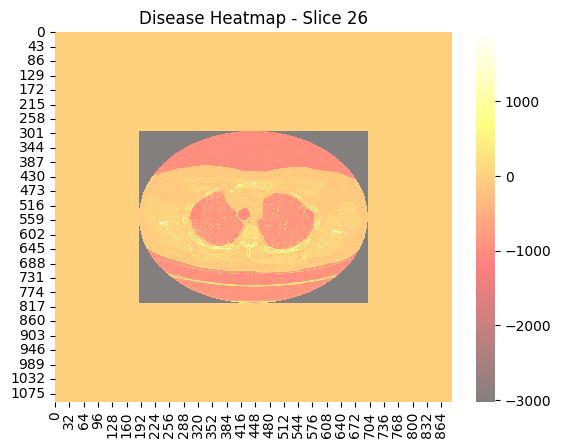

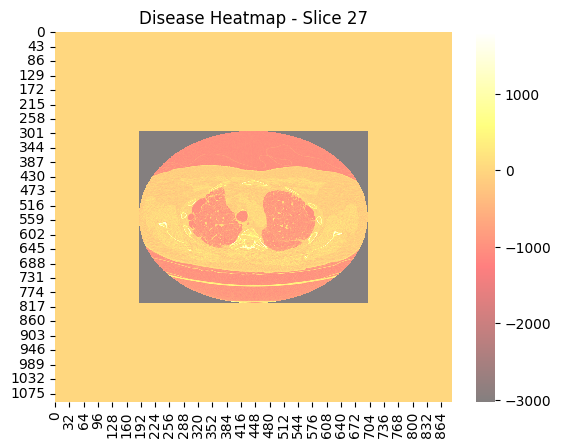

['ct_scan_disease_spread_calculator.joblib']

In [74]:
# Display heatmaps of affected areas for each slice
for i, slice in enumerate(image_slices):
    plt.figure()
    sns.heatmap(slice, cmap='hot', alpha=0.5)
    plt.title(f'Disease Heatmap - Slice {i}')
    plt.show()

# Plotly graph for slice-wise affected area visualization
slices_df = pd.DataFrame({'Slice': range(len(affected_areas)), 'Affected Area': affected_areas})
slices_df['Smoothed Affected Area'] = gaussian_filter1d(slices_df['Affected Area'], sigma=1.5)

# Plot with Plotly
fig = px.line(
    slices_df, x='Slice', y='Smoothed Affected Area',
    title=f"Affected Area per Slice in CT Scan - Spread Category: {spread_category}",
    labels={'Slice': 'CT Slice', 'Smoothed Affected Area': 'Affected Area (pixels)'}
)
fig.update_traces(line=dict(color='firebrick'))

# Highlight peaks in the affected areas
peak_threshold = max(affected_areas) * 0.9
peak_slices = slices_df[slices_df['Affected Area'] >= peak_threshold]

fig.add_trace(go.Scatter(
    x=peak_slices['Slice'], y=peak_slices['Smoothed Affected Area'],
    mode='markers', name='High Affected Area',
    marker=dict(color='blue', size=8, symbol='circle-open')
))

# Add shaded bands for affected area levels
fig.add_shape(type="rect", x0=0, x1=len(affected_areas)-1, y0=0, y1=5000, fillcolor="green", opacity=0.2)
fig.add_shape(type="rect", x0=0, x1=len(affected_areas)-1, y0=5000, y1=15000, fillcolor="yellow", opacity=0.2)
fig.add_shape(type="rect", x0=0, x1=len(affected_areas)-1, y0=15000, y1=30000, fillcolor="orange", opacity=0.2)
fig.add_shape(type="rect", x0=0, x1=len(affected_areas)-1, y0=30000, y1=max(affected_areas), fillcolor="red", opacity=0.2)

fig.update_layout(showlegend=True, legend_title_text='Legend')
fig.show()

# Save the model for reuse
joblib.dump(calculate_disease_spread, 'ct_scan_disease_spread_calculator.joblib')

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import uniform, randint

# Load dataset
# train_data = pd.read_csv('path_to_your_data.csv')  # Uncomment to load data

# Separate features and target
X = train_data.drop(columns=['FVC'])
y = train_data['FVC']

# Define categorical and numerical columns
categorical_cols = ['Sex', 'SmokingStatus']
numerical_cols = ['Weeks', 'Percent', 'Age']

# Numerical transformer with polynomial features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Include polynomial features
])

# Categorical transformer with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Gradient Boosting Model with hyperparameter tuning
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])

# Hyperparameter search space
param_distributions = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(3, 10),
    'model__min_samples_split': randint(2, 10)
}

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomizedSearchCV for hyperparameter tuning
search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Adjust based on resources
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit the search to the training data
search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_model = search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
print(f'Optimized Mean Absolute Error: {mae}')

# Optionally, check the best hyperparameters found
print(f'Best hyperparameters: {search.best_params_}')

Optimized Mean Absolute Error: 138.4935023377412
Best hyperparameters: {'model__learning_rate': 0.04824619912671628, 'model__max_depth': 6, 'model__min_samples_split': 9, 'model__n_estimators': 230}


In [76]:
import joblib

# Path to save the model
model_path = 'gradient_boosting_model_pipeline.joblib'

# Save the model pipeline
joblib.dump(model_pipeline, model_path)
print(f"Model pipeline saved to {model_path}")


Model pipeline saved to gradient_boosting_model_pipeline.joblib
